# Описание проекта

**Проект по теме "Принятие решений в бизнесе на основе данных"** 

Мы - интернет-магазин. На текущий момент мы располагаем пулом гипотез о том, как нам увеличить показатели нашего сервиса, а также данными А/В-тестирования одной из гипотез на протяжении 1 месяца (август 2019 года). 

В рамках проекта стоят следующие задачи:

1. Произвести приоритизацию гипотез, используя фреймворки ICE и RICE и уже присвоенные гипотезам параметры. Установить, какие из гипотез рекомендуется протестировать в первую очередь
2. Обработать данные А/В-тестирования:
    + Сделать вывод по результатам тестирования 
    + Дать рекомендацию относительно дальнейших действий в рамках тестирования (продолжить тест или остановить)

# Подготовка данных 

## Импорт библиотек и чтение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
#читаем датасет с гипотезами
hypotheses = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
#читаем датасет с заказами пользователей 
orders = pd.read_csv('/datasets/orders.csv')

#читаем датасет с данными о посещениях
visitors = pd.read_csv('/datasets/visitors.csv')

## Предобработка данных

### Таблица `hypotheses`

In [4]:
#Для начала посмотрим на характеристики таблицы в целом
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Таблица крайне небольшая. Кроме того, она полность заполнена данными. Посмотрим на нее целиком:

In [5]:
display(hypotheses)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Достаточно достаточно мала для полной визуальной оценки содержимого. Никаких проблем нет.

### Таблица `orders`

In [6]:
#оценим таблицу
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [8]:
#преобразуем данные в столбце с датами с текстового формата в дату
orders['date'] = pd.to_datetime(orders['date'])

#найдем минимальное и максимальное значение даты - так мы убедимся, что анализируемый период в порядку
print(orders['date'].min())
print(orders['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


In [9]:
#посмотрим, нет ли в столбце с группой посторонних значений
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

1. Преобразовали дату из текстового формата в формат даты
2. Период анализа - 1 месяц (август 2019 года), что подтверждается максимальной и минимальной датой из ряда
3. Посторонних значений в столбце с группой нет
4. Пропусков в данных нет

### Таблица `visitors`

In [10]:
#взглянем на таблицу
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [11]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [12]:
#устраним аналогичную проблему - преобразуем дату из текстового формата в формат даты
visitors['date'] = pd.to_datetime(visitors['date'])

In [13]:
#оценим период
print(visitors['date'].min())
print(visitors['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


In [14]:
#также посмотрим значения столбца с группой на предмет посторонних значений 
visitors['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

1. Преобразовали дату из текстового формата в формат даты
2. Период анализа - 1 месяц (август 2019 года), что подтверждается максимальной и минимальной датой из ряда
3. Посторонних значений в столбце с группой нет
4. Пропусков в данных нет

## Заключение по результатам предобработки данных

1. Мы располгаем тремя таблицами: 
    + Таблица с гипотезами относительно дальнейшего развития сервиса. 
    + Таблица с заказами покупателей магазина в период 1-31 августа 2019 года
    + Таблица с суммарным количеством посетителей по датам и группам в период 1-31 августа 2019 года
    
2. Таблица `hypotheses` содержит 9 гипотез, каждой из которых присвоены числовые оценки от 1 до 10 по четырем параметрам. Типы данных в таблице корректны, оценки находятся в пределах необходимого диапазона (1-10). Дополнительные действия по таблице не потребовались

3. Таблица `orders`:
    + Содержит по 5 параметров каждого наблюдения:
        - Идентификатор заказа
        - Идентификатор пользователя совершившего заказ
        - Дату заказа 
        - Сумму заказа 
        - Группу, к которой относится пользователь в рамках А/В-тестирования
    + Состоит из 1197 записей и не содержит пропусков ни в одном из столбцов
    + Имеет корректный тип данный 4 из 5 столбцов - потребовалось преобразование даты из строкового формата данных в формат даты
    
4. Таблица `visitors` содержит агрегированные данные, сгруппированные по дате и группе пользователя в рамках А/В-теста:
    + Состоит из 62 записей (по 31 записи на каждую группу пользователей в рамках рассматриваемого периода с 1 по 31 августа 2019 года)
    + Таблица не содержит пропусков 
    + Имеет корректный тип данных во всех столбцах, кроме столбца с датой, что потребовало преобразование из формата строки в формат даты
    
    
**В целом, данные можно характеризовать как хорошо структурированные и "технически чистые" - дополнительное решение по заполнению пропусков не потребовалось**

# Приоритизация гипотез

## Фреймворк `ICE`

In [15]:
#повторно выведем содержимое таблицы с гипотезами
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
display(hypotheses)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Для расчета оценки каждой из гипотез в соответствии с фреймворком ICE нам необходимо воспользоваться следующей формулой:

ICE Score = Impact * Confidence / Efforts

In [16]:
#добавим в таблицу hypotheses столбец с оценкой по фреймворку ICE 
#и округлим полученное значение до 1 знака после точки
hypotheses['ICE'] = ((hypotheses['Impact']*hypotheses['Confidence'])/hypotheses['Efforts']).round(1)

In [17]:
#повторно выведем таблицу, но с сортировкой по столбцу с оценкой по фреймворку ICE
display(hypotheses[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Мы получили перечень гипотез, отсортированный по убыванию оценки ICE. В топ5 входят гипотезы с индексами 8, 0, 7, 6 и 2.  

## Фреймворк `RICE`

Для расчета оценки каждой из гипотез в соответствии с фреймворком RICE нам необходимо воспользоваться следующей формулой:

RICE Score = Reach * Impact * Confidence / Efforts

In [18]:
#добавим в таблицу hypotheses столбец с оценкой по фреймворку RICE 
#и округлим полученное значение до 1 знака после точки
hypotheses['RICE'] = (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Efforts']

In [19]:
#повторно выведем таблицу, но с сортировкой по столбцу с оценкой по фреймворку ICE
display(hypotheses[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Мы наблюдаем изменение порядка гипотез. Теперь топ5 выглядит следующим образом: 7, 2, 0, 6, и 8.

## Разница в приоритизации гипотез при использовании разных фреймворков

In [20]:
#для простоты восприятия добавим столбцы с рангами значений оценок
hypotheses['ICE_rank'] = hypotheses['ICE'].rank(ascending=False).astype('int')
hypotheses['RICE_rank'] = hypotheses['RICE'].rank(ascending=False).astype('int')

#также посчитаем разность между ранками для визуального распознавания наибольших "разрывов" в оценках
hypotheses['rank_difference'] = hypotheses['ICE_rank'] - hypotheses['RICE_rank']

In [21]:
display(hypotheses.sort_values(by='RICE_rank'))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE,ICE_rank,RICE_rank,rank_difference
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0,3,1,2
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0,5,2,3
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0,2,3,-1
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0,4,3,1
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2,1,5,-4
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0,8,6,2
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0,6,7,-1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0,7,7,0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0,9,9,0


<span style="text-decoration:underline">Выводы:</span>

1. Наибольшее изменение (-4 строки) у гипотезы "Запустить акцию, дающую скидку на товар в день рождения". Мы видим, что предполагаемый эффект этого нововведения практически максимальный (9 из 10 баллов). Кроме того, уверенность в оценках также высока, однако охват аудитории (который мы учитываем только в RICE) минимален - 1 балл при относительно высоких затратах на реализацию. Это звучит разумно, так как результатами акции сможет воспользоваться очень небольшое количество людей, что и смещает гипотезу с первого места на пятое.

2. Аналогичная ситуация наблюдается с двумя другими гипотезами, у которых смещение вниз по рейтингу при использовании RICE не такое большое (-1 позиция). У обеих гипотез небольшой охват аудитории и довольно высокие затраты на реализацию (у гипотезы "Запустить собственную службу доставки, что сократит срок доставки заказов" они максимальные)

3. Гипотезы 7 и 9 места не изменили свое положение в списке, так как в целом имеют невысокие оценки по всем параметрам и склонны находится в нижней части списка на реализацию

4. Мы наблюдаем и обратную ситуацию: 2 гипотезы продвинулись вверх в списке с 3 на 1 и с 5 на 2 места. 
    + Гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" имеет относительно высокие оценки для фреймворка ICE (7 и 8) при средних затратах (5), что изначально делало ее мощным претендентом на реализацию, но как только мы приняли во внимание охват аудитории (который у данной гипотезы максимален), это доработка существенно продвинулась в списке. Преимущество решения понятно - это способ настроить дополнительный канал донесения информации до потенциальных и действующих клиентов и охват его максимален для согласившихся на подписку
    + Гипотеза "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" также продвинулась. С одной стороны эффект от внедрения ниже среднего, а с другой - охват, близкий к максимальному и низкие затраты на реализацию, что потенциально является быстрым способом немного повысить конверсию и, соответственно, выручку

# Анализ A/B-теста

## График кумулятивной выручки по группам

In [22]:
#сформируем датафрейм, в котором сохраним даты и группы пользователей в A/B-тесте
datesGroups = orders[['date', 'group']].drop_duplicates()

In [23]:
#нам необходимо сформировать датафрейм, где мы сохраним кумулятивный итог по каждой паре дата/группа за 
#период нашего теста

#для начала обратимся к вышесформированной таблице с датами и группами, применив к ней лямбда-функцию, которая
ordersAggregated = datesGroups.apply(
    lambda x: orders[ #для каждой строки в datesGroups обращается к датафрейму с заказами
        np.logical_and( #отбирает из него строки для которых совпадают два условия через логическое "и"
            orders['date'] <= x['date'], orders['group'] == x['group'] #дата <= означает, что с каждым днем от начала периода мы будем отбирать все больше строк
        )
    ].agg({ #далее к отобранным данным мы применяем агрегирующие функции
        'date': 'max', #для сохранения результирующей даты 
        'group': 'max', #для сохранению группы
        'transactionId': pd.Series.nunique, #отбираем количество уникальных заказов 
        'visitorId': pd.Series.nunique, #и количество уникальных пользователей 
        'revenue': 'sum' #суммируем выручку по строке datesGroups для всех отобранных строк
    }
    ),
    axis=1, #функцию применяем по горизонтали
).sort_values(by=['date', 'group']) #и сортируем итог сначала по убыванию дат, а внутри дат по убыванию групп                

In [24]:
#изменим наименования столбцов в таблице
ordersAggregated.columns=[
    'date',
    'group',
    'orders',
    'buyers',
    'revenue'
]

#оценим полученную таблицу
ordersAggregated.head()

,date,group,orders,buyers,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


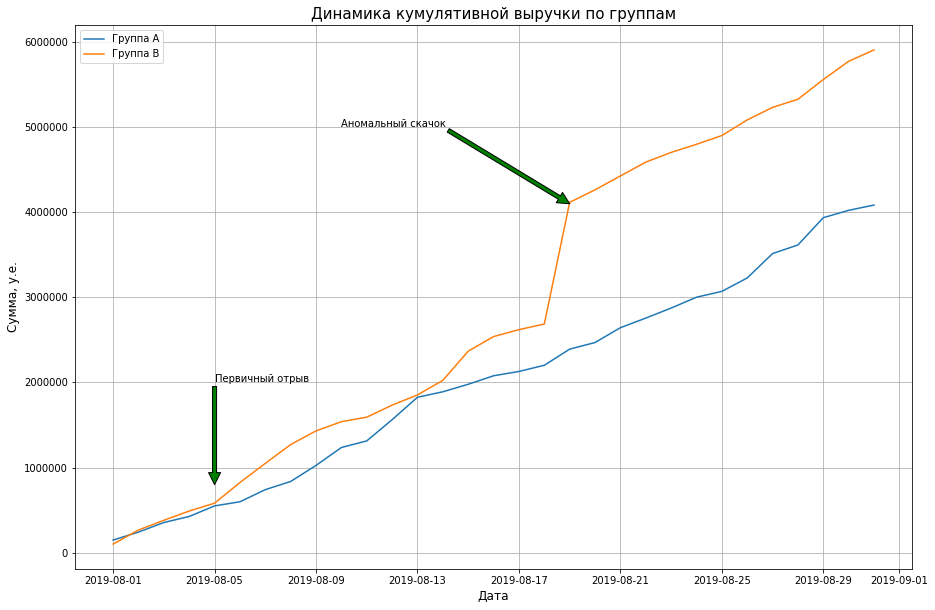

In [25]:
#для построения графика динамики изменения кумулятивной выручки нам необходимо сформировать
plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Динамика кумулятивной выручки по группам', fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма, у.е.', fontsize=12)


plt.plot(
    ordersAggregated[ordersAggregated['group'] == 'A']['date'], 
    ordersAggregated[ordersAggregated['group'] == 'A']['revenue'],
    label='Группа A')

plt.plot(
    ordersAggregated[ordersAggregated['group'] == 'B']['date'], 
    ordersAggregated[ordersAggregated['group'] == 'B']['revenue'],
    label='Группа B')

plt.annotate('Аномальный скачок', xy=('2019-08-19', 4100000), xytext=('2019-08-10', 5000000),
            arrowprops=dict(facecolor='g'))
plt.annotate('Первичный отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g'))

plt.legend()
plt.show()

<span style="text-decoration:underline">Наблюдения:</span>

1. С 1 по 5 августа кумулятивная выручка по группам теста была сопоставима
2. В период с 5 по 13 между группами наблюдается разрыв в пользу группы "В". Следует обратить внимание, что разрыв рос с 5 по 9 августа, а далее начал сокращаться
3. 13 августа линии графика практически встретились в одной точке. С этого момента между группами снова начал нарастать разрыв между группами
4. 18 августа график роста кумулятивной выручки показал необычную динамику роста в группе "В", что примерно в 4 раза увеличило разрыв между группами. Далее рост выручки продолжился в обеих группах с сопоставимым разрывом (примерно с 25 августа мы видим небольшое сокращение разрыва)


<span style="text-decoration:underline">Выводы:</span>

1. График показывает, что в целом кумулятивная выручка в группе "В" растет выше
2. Всплекс от 18 августа скорее обусловлен каким-то непрогнозируемым колебанием для пары количество заказов * средний чек по заказу. Это имеет смысл изучить дополнительно, либо увеличить длительность теста.

## График кумулятивного среднего чека по группам

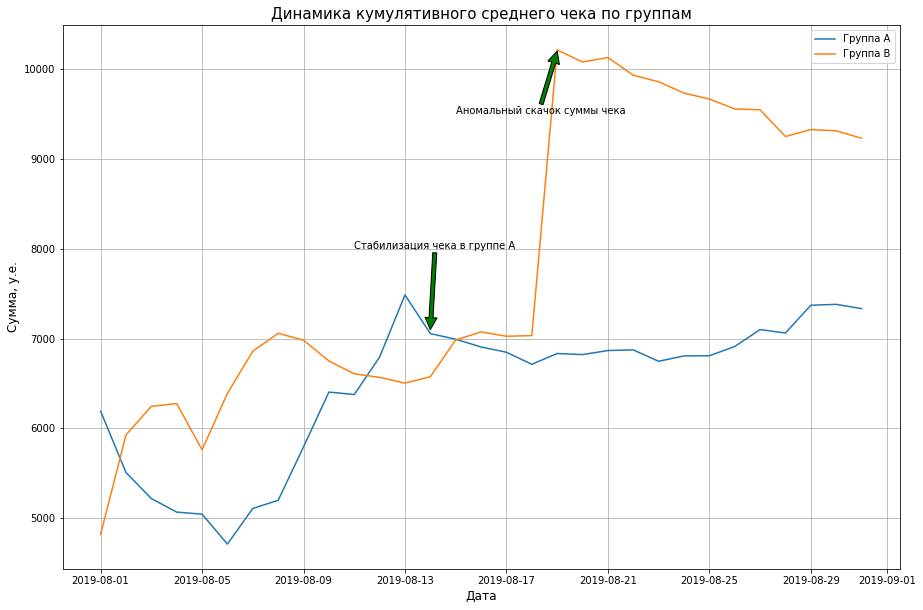

In [26]:
#построим график изменения среднего чека по группам
plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Динамика кумулятивного среднего чека по группам', fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма, у.е.', fontsize=12)

plt.plot(
    ordersAggregated[ordersAggregated['group'] == 'A']['date'], 
    ordersAggregated[ordersAggregated['group'] == 'A']['revenue']/ordersAggregated[ordersAggregated['group'] == 'A']['orders'],
    label='Группа A')

plt.plot(
    ordersAggregated[ordersAggregated['group'] == 'B']['date'], 
    ordersAggregated[ordersAggregated['group'] == 'B']['revenue']/ordersAggregated[ordersAggregated['group'] == 'B']['orders'],
    label='Группа B')

plt.annotate('Стабилизация чека в группе А', xy=('2019-08-14', 7100), xytext=('2019-08-11', 8000),
            arrowprops=dict(facecolor='g'))
plt.annotate('Аномальный скачок суммы чека', xy=('2019-08-19', 10200), xytext=('2019-08-15', 9500),
            arrowprops=dict(facecolor='g'))

plt.legend()
plt.show()

Так как сумма среднего чека при оценке динамики ее изменения может изменяться в меньшую сторону в отличие от кумулятивной выручки, мы можем выдвинуть более детализированные предположения: 

1. На старте средний чек в группе В показал уверенный рост на фоне параллельного снижения чека в группе А - это любопытный факт, который приводит к вопросу относительно перекрестного влияния двух групп
2. В промежутке между 5 и 10 августа мы можем наблюдать последовательный рост среднего чека сначала в группе В, а потом в группе А. Учитывая угол наклона графика (почти идентичный) мы можем предположить, что в этом временном промежутке произошло некоторое событие, которое дало отложенный эффект и для группы А 
3. 13 августа мы наблюдаем некоторое снижение (примерно до отметки в 6.5 тысяч) среднего чека группы В и пиковое значение метрики для группы А (около 7.5 тысяч). В целом, можно предположить, что период 1-15 августа выступил неким "периодом турбулентности", когда изменение среднего чека в группах было очень резким в обе стороры. Это подтверждается в том числе относительно стабильной линией среднего чека в группе А
4. На графике динамики среднего чека также наблюдается резкий скачок суммы среднего чека (с 7 до 10+ тысяч) для группы В - вероятно в этот день прозошло несколько очень крупных заказов - предположительно мы привлекли какой-то новый сегмент аудитории, либо увеличили глубину чека
5. В последней трети анализируемого периода мы снова наблюдаем плавный рост среднего чека группы А при снижении чека группы В, однако разрыв примерно в 1800-2000 у.е. между группами сохраняется. 

## График относительного изменения кумулятивного среднего чека группы B к группе A

In [27]:
#сформируем датафрейм, куда запишем кумулятивные данные по заказам для двух групп
cumulativeRevenueA = ordersAggregated[ordersAggregated['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = ordersAggregated[ordersAggregated['group'] == 'B'][['date', 'revenue', 'orders']]
cumulative_revenue = cumulativeRevenueA.merge(cumulativeRevenueB, on='date', how='left', suffixes=['A', 'B'])

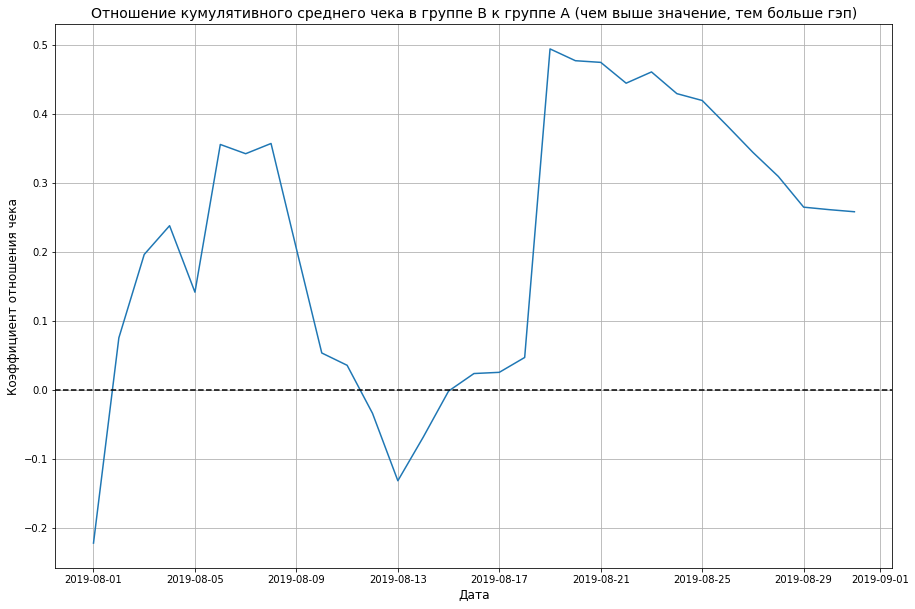

In [28]:
plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Отношение кумулятивного среднего чека в группе В к группе А (чем выше значение, тем больше гэп)', 
          fontsize=14)

plt.plot(
    cumulative_revenue['date'],
    ((cumulative_revenue['revenueB'] / cumulative_revenue['ordersB'])/(cumulative_revenue['revenueA'] / cumulative_revenue['ordersA'])-1)
)

plt.xlabel('Дата', fontsize=12)
plt.ylabel('Коэффициент отношения чека', fontsize=12)

plt.axhline(y=0, color='black', linestyle='--')

plt.show()

1. Мы видим значительный рост в самом начале теста (1-4 августа). Мы могли бы предположить, что эффективность нововведения, которые мы использовали в группе В высока, однако скорее всего такое колебание обусловлено какими-то другими факторами
2. С 7 по 13 августа наблюдается снижение (второе из двух за весь период теста, которые опустилось ниже нулевого коэффициента) - как мы видели на графике выше это было обусловлено тенденцией сближения суммы средних чеков в этот период - вероятно, спрос на продукт был обусловлен каким-то третьим фактором
3. На графике также виден аномальный рост 18 августа и последующее снижение. 18 августа явно произошло какое-то "нетрадиционное" колебание спроса. Вероятно, необходимо отбросить в данных экстремальные значения, чтобы график был более пологим и наглядным для оценки эффективности нашего нововведения.

## График кумулятивной конверсии по группам

Для подсчета конверсии нам потребуется также информация о количестве пользователей, которые посетили наш ресурс за период теста. 

In [29]:
#по аналогии с кумулятивными данными по заказам, формируем таблицу с кумулятивными данными по посетителям
visitorsAggreagted = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({
        'date': 'max',
        'group': 'max',
        'visitors': 'sum'
    }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [30]:
#формируем сборный датафрейм с кумулятивными данными и заказах и посетителях ресурса
cumulative_data = ordersAggregated.merge(visitorsAggreagted, on=['date', 'group'], how='left')

In [31]:
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [32]:
#посчитаем и добавим конверсию в виде отдельного столбца в датафрейм с кумулятивными данными
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

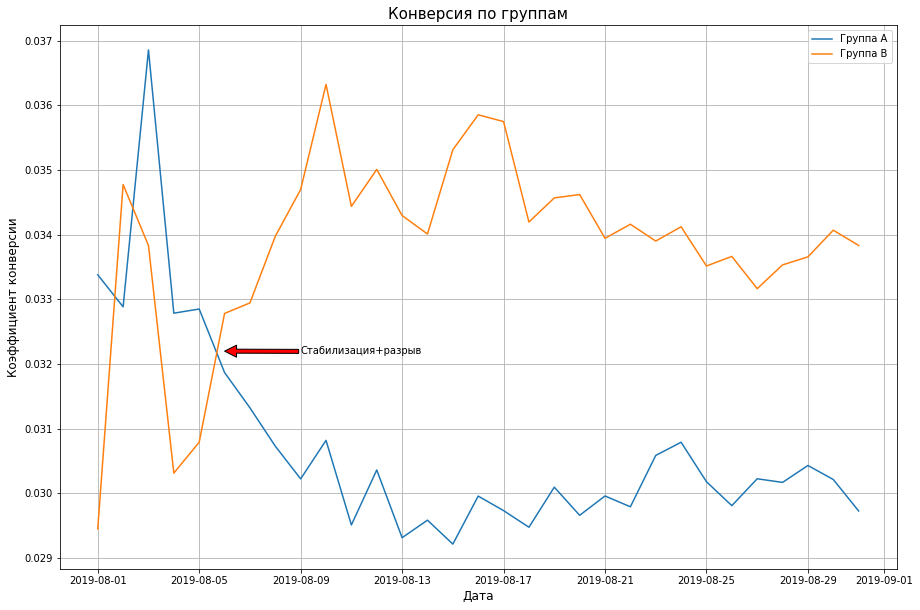

In [33]:
#построим график изменения среднего чека по группам
plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Конверсия по группам', fontsize=15)

plt.xlabel('Дата', fontsize=12)
plt.ylabel('Коэффициент конверсии', fontsize=12)

plt.annotate('Стабилизация+разрыв', xy=('2019-08-06', 0.0322), xytext=('2019-08-09', 0.03215),
            arrowprops=dict(facecolor='r'))

plt.plot(
    cumulative_data[cumulative_data['group'] == 'A']['date'], 
    cumulative_data[cumulative_data['group'] == 'A']['conversion'],
    label='Группа A')

plt.plot(
    cumulative_data[cumulative_data['group'] == 'B']['date'], 
    cumulative_data[cumulative_data['group'] == 'B']['conversion'],
    label='Группа B')

plt.legend()
plt.show()

1. В период с 1 по 6 августа наблюдаются сильные колебания конверсии в обеих группах
2. С 6 августа намечается тенденция на фиксацию относительно устойчивого различия в конверсии между группами (в группе А конверсия колеблется у отметки в 3%, а в группе В в диапазоне 3.3-3.6%. Такая конверсия в обеих группах в общем может говорить об эффективности нововведения для повышения конверсии.

## График относительного изменения кумулятивной конверсии группы B к группе A

In [34]:
#для подсчета отношения конверсии по группам сформируем две переменные, в каждую из которых запишем датафрейм
#содержащий данные для разных групп
cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B']

#сольем данные двух датафреймов, сохранив столбцы с датой и конверсией 
cumulative_conversion_merged = cumulative_data_A[['date', 'conversion']
                                                ].merge(cumulative_data_B[['date', 'conversion']],
                                                       on='date',
                                                       how='left',
                                                       suffixes=['A', 'B'])

In [35]:
cumulative_conversion_merged.head(5)

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


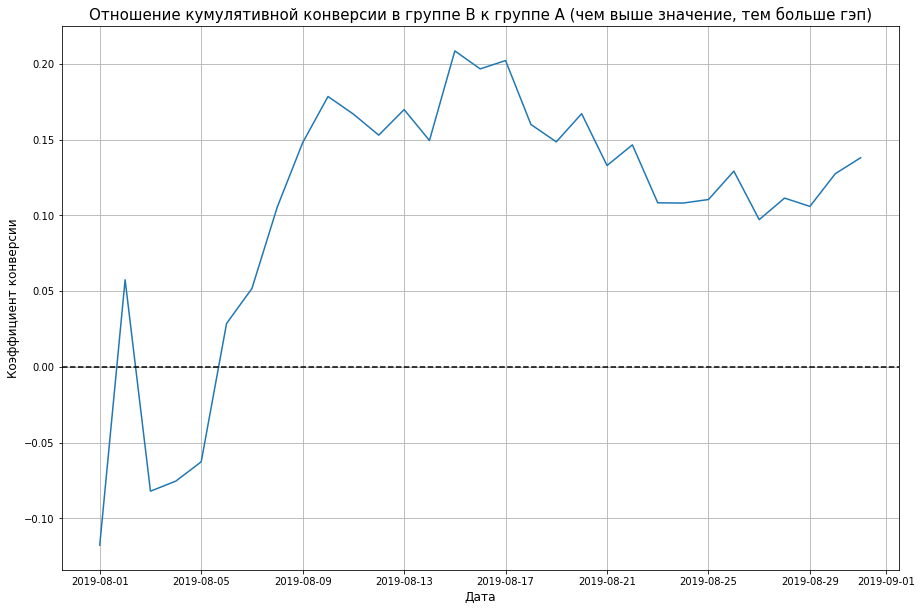

In [36]:
plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Отношение кумулятивной конверсии в группе В к группе А (чем выше значение, тем больше гэп)', 
          fontsize=15)

plt.xlabel('Дата', fontsize=12)
plt.ylabel('Коэффициент конверсии', fontsize=12)

plt.plot(
    cumulative_conversion_merged['date'],
    (cumulative_conversion_merged['conversionB']/cumulative_conversion_merged['conversionA']-1)
)

plt.axhline(y=0, color='black', linestyle='--')

plt.show()

1. По аналогии с графиками, которые мы оценивали ранее, можем наблюдать некий период "успокоения" колебаний с 1 по 6 августа. В этот период наблюдаются резкие скачки отношения конверсии группы В к группе А - в 4 из 6 дней коэффициент отношения опускается ниже нулевой отметки, что говорит о более высоком уровне конверсии в группе А
2. С 6 августа наблюдается тенденция к росту разрыва между конверсиями двух групп. Это продолжалось до 17 августа - далее наблюдается коррекция уровней конверсии в двух группах. По времени начало периода коррекции совпадает со скачком выручки и среднего чека в группе В, что вызывает вопросы относительно однородности структуры спроса и наводит на мысль о необходимости более глубинного изучения аномалии. 

## Точечный график количества заказов по пользователям

In [37]:
#для построения точеченого графика нам потребуется список с количеством заказов на каждого пользователя
#повторно взглянем на наименования столбцов, с которыми нам предстоит работать 
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [38]:
#формируем такой список и переименовываем в нем столбцы
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers.columns=['user_id', 'orders']

In [39]:
#посмотрим на результат
ordersByUsers.sort_values(by='orders', ascending=False).head()

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


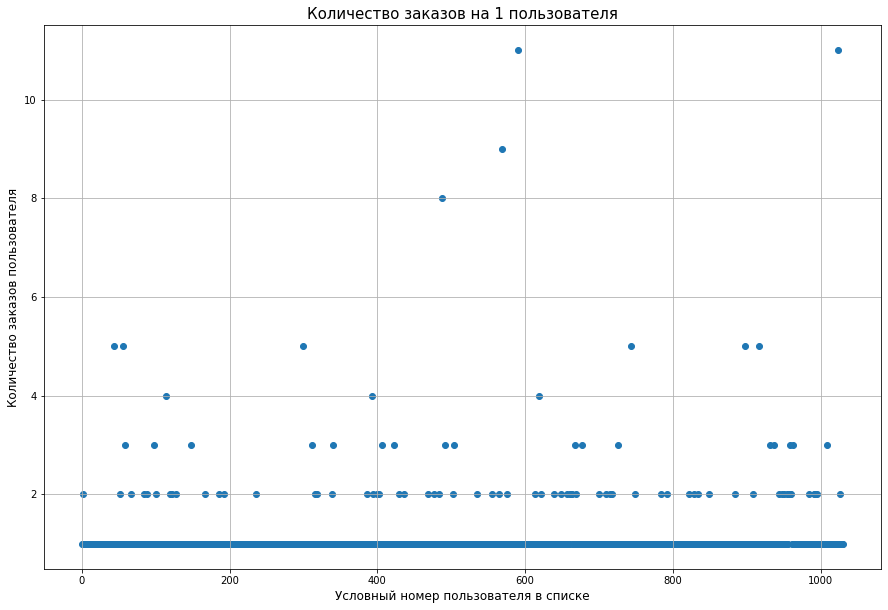

In [40]:
#для наглядного понимания распределения заказов на всю глубину списка нам потребуются корректные данные для оси Х
#ее мы сформируем как список числовых значение от 0 до числа записей в списке
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Количество заказов на 1 пользователя', fontsize=15)

plt.xlabel('Условный номер пользователя в списке', fontsize=12)
plt.ylabel('Количество заказов пользователя', fontsize=12)

plt.scatter(x_values, ordersByUsers['orders'])

plt.show()

1. Судя по виду графика на отметке в 1 заказ на пользователя (график похож на линию), основная часть пользователей предпочитает совершать 1 заказ
2. Отметка в 2 заказа также выглядит достаточно плотно с визуальной точки зрения - мы видим, что в некоторых местах точки продолжаются сливаться
3. После отметки в 2 заказа на пользователя точки графика стоновятся все более разреженными - вероятно в этом сегменте могут наблюдаться аномальные значения (в том числе те, что наблюдаются на графиках выше) 

## 95-й и 99-й перцентили количества заказов на пользователя

In [41]:
print('90% пользователей за время теста совершили заказов: {0:.0f}'.format(np.percentile(ordersByUsers['orders'], 90)))
print('95% пользователей за время теста совершили заказов: {0:.0f}'.format(np.percentile(ordersByUsers['orders'], 95)))
print('98% пользователей за время теста совершили заказов: {0:.0f}'.format(np.percentile(ordersByUsers['orders'], 98)))
print('99% пользователей за время теста совершили заказов: {0:.0f}'.format(np.percentile(ordersByUsers['orders'], 99)))

90% пользователей за время теста совершили заказов: 1
95% пользователей за время теста совершили заказов: 2
98% пользователей за время теста совершили заказов: 3
99% пользователей за время теста совершили заказов: 4


In [42]:
print('97% пользователей за время теста совершили заказов: {0:.0f}'.format(np.percentile(ordersByUsers['orders'], 97)))

97% пользователей за время теста совершили заказов: 2


1. 95% пользователей совершили 2 заказа или менее за время теста
2. 98% пользователей совершили 3 заказа или более за время теста. Следует отметить, что значение в 3 заказа начинает фигурировать только с этой отметки. **Таким образом, 97% процентов пользователей совершили на более 2 заказов за время теста - на этой отметке мы зафиксируем границу.**

## Точечный график стоимостей заказов

In [43]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


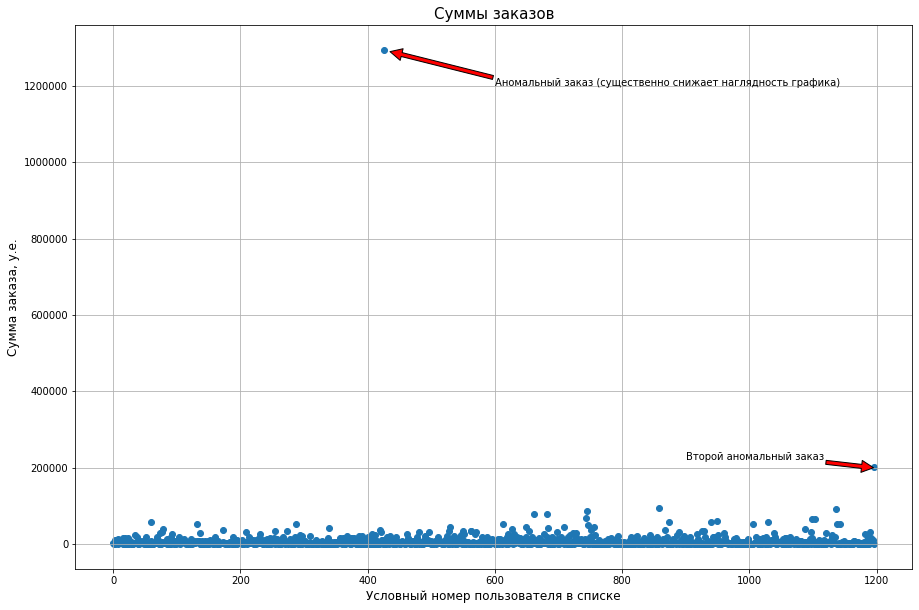

In [44]:
#по аналогии с графиком выше сформируем список числовых значений от нуля до числа элементов в списке заказов
x_values = pd.Series(range(0, len(orders)))

plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Суммы заказов', fontsize=15)

plt.xlabel('Условный номер пользователя в списке', fontsize=12)
plt.ylabel('Сумма заказа, у.е.', fontsize=12)

plt.scatter(x_values, orders['revenue'])

plt.annotate('Аномальный заказ (существенно снижает наглядность графика)',
             xy=(435, 1290000),
             xytext=(600, 1200000),
            arrowprops=dict(facecolor='r'))

plt.annotate('Второй аномальный заказ',
             xy=(1195, 200000),
             xytext=(900, 220000),
            arrowprops=dict(facecolor='r'))

plt.show()

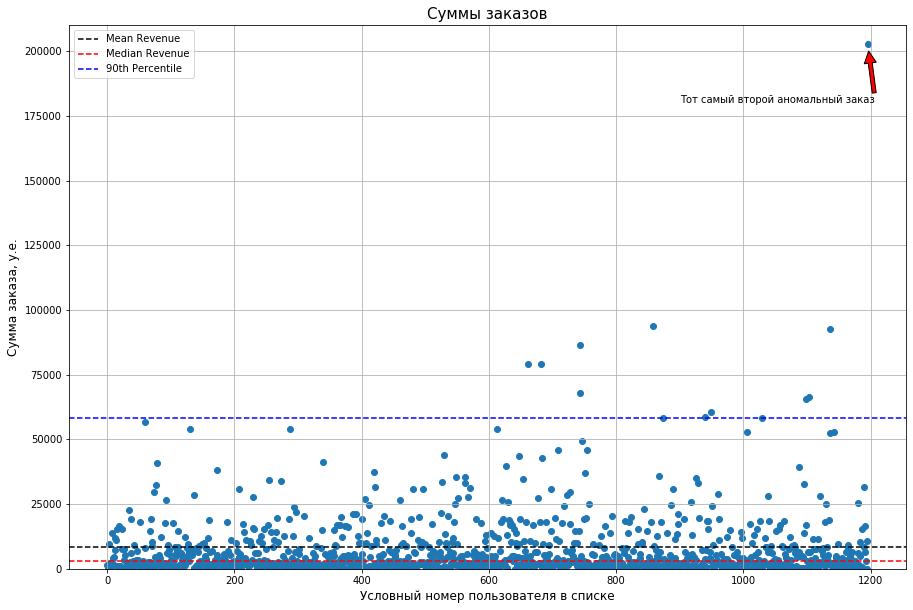

In [45]:
#по аналогии с графиком выше сформируем список числовых значений от нуля до числа элементов в списке заказов
x_values = pd.Series(range(0, len(orders)))

plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Суммы заказов', fontsize=15)
plt.ylim(0,210000)

plt.scatter(x_values, orders['revenue'])

plt.axhline(y=np.mean(orders['revenue']), color='black', linestyle='--', label='Mean Revenue')
plt.axhline(y=np.median(orders['revenue']), color='red', linestyle='--', label='Median Revenue')
plt.axhline(y=np.percentile(orders['revenue'], 99), color='blue', linestyle='--', label='90th Percentile')

plt.xlabel('Условный номер пользователя в списке', fontsize=12)
plt.ylabel('Сумма заказа, у.е.', fontsize=12)

plt.annotate('Тот самый второй аномальный заказ',
             xy=(1197, 200000),
             xytext=(900, 180000),
            arrowprops=dict(facecolor='r'))

plt.legend()
plt.show()

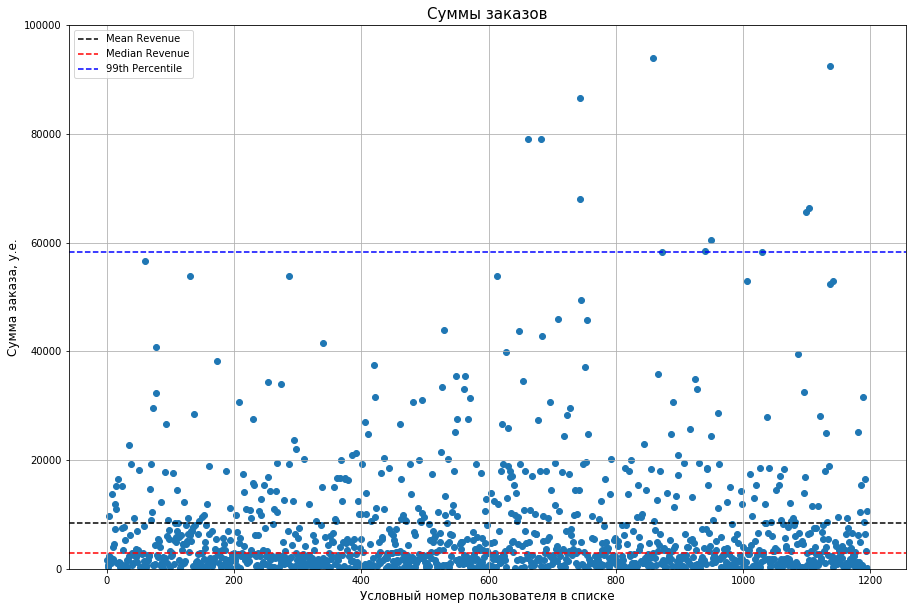

In [46]:
#по аналогии с графиком выше сформируем список числовых значений от нуля до числа элементов в списке заказов
x_values = pd.Series(range(0, len(orders)))

plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Суммы заказов', fontsize=15)
plt.ylim(0,100000)

plt.scatter(x_values, orders['revenue'])

plt.axhline(y=np.mean(orders['revenue']), color='black', linestyle='--', label='Mean Revenue')
plt.axhline(y=np.median(orders['revenue']), color='red', linestyle='--', label='Median Revenue')
plt.axhline(y=np.percentile(orders['revenue'], 99), color='blue', linestyle='--', label='99th Percentile')

plt.xlabel('Условный номер пользователя в списке', fontsize=12)
plt.ylabel('Сумма заказа, у.е.', fontsize=12)

plt.legend()
plt.show()

1. На первом графике распределение стоимостей заказов показано не слишком наглядно. Мы видим два явных выброса (один из которых определяет предел оси Y):
    + Точка на отметке около 200 тысяч
    + Точка на отметке около 1.3 млн (это значение очень сильно "прессует" график по вертикали, поэтому остальные заказы просто похожи на тонкую полоску - однако даже так мы видим, что большая часть лежит ниже отметки в 100 тысяч
2. На втором графике мы исключили значения свыше 210 тысяч, поэтому на нем представлен только 1 выброс. Здесь уже достаточно хорошо видно, что большая часть заказов лежит существенно ниже 100 тысяч. Примерно около отметки в 60 тысяч. 
3. Устранив выброс на отметке в 210 тысяч (ограничение оси Y на 100 тысячах) мы получаем еще более наглядный график, который по-прежнему включает более 99% заказов, так как горизонтальная линия 99го перцентиля лежит все еще на плоскости. Таким образом, мы можем предположить, что выборка стоимостей заказов за время теста содержит достаточно значений, которые могут быть в том числе причиной аномалии, наблюдаемой ранее на графиках

## 95-й и 99-й перцентили стоимости заказов

In [47]:
print('Сумма 90% заказов не превышает: {0:.0f} условных единиц'.format(np.percentile(orders['revenue'], 90)))
print('Сумма 95% заказов не превышает: {0:.0f} условных единиц'.format(np.percentile(orders['revenue'], 95)))
print('Сумма 96% заказов не превышает: {0:.0f} условных единиц'.format(np.percentile(orders['revenue'], 96)))
print('Сумма 97% заказов не превышает: {0:.0f} условных единиц'.format(np.percentile(orders['revenue'], 97)))
print('Сумма 98% заказов не превышает: {0:.0f} условных единиц'.format(np.percentile(orders['revenue'], 98)))
print('Сумма 99% заказов не превышает: {0:.0f} условных единиц'.format(np.percentile(orders['revenue'], 99)))

Сумма 90% заказов не превышает: 18168 условных единиц
Сумма 95% заказов не превышает: 28000 условных единиц
Сумма 96% заказов не превышает: 31382 условных единиц
Сумма 97% заказов не превышает: 35485 условных единиц
Сумма 98% заказов не превышает: 44133 условных единиц
Сумма 99% заказов не превышает: 58233 условных единиц


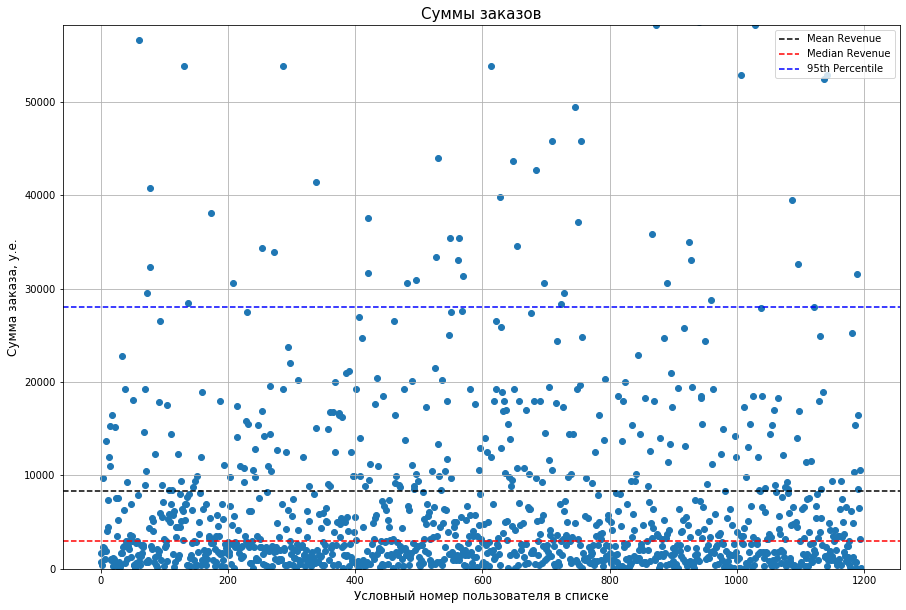

In [48]:
x_values = pd.Series(range(0, len(orders)))

plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Суммы заказов', fontsize=15)
plt.ylim(0,np.percentile(orders['revenue'], 99))

plt.scatter(x_values, orders['revenue'])

plt.axhline(y=np.mean(orders['revenue']), color='black', linestyle='--', label='Mean Revenue')
plt.axhline(y=np.median(orders['revenue']), color='red', linestyle='--', label='Median Revenue')
plt.axhline(y=np.percentile(orders['revenue'], 95), color='blue', linestyle='--', label='95th Percentile')

plt.xlabel('Условный номер пользователя в списке', fontsize=12)
plt.ylabel('Сумма заказа, у.е.', fontsize=12)

plt.legend()
plt.show()

In [49]:
#для получения дополнительной информации для принятия решения границе стоимости построим график изменения суммы 
#заказа для процентилей с 90 по 99
percentiles = pd.DataFrame.from_dict(
    {x: np.percentile(orders['revenue'], x).round(2) for x in range(90, 100)}, orient='index')
percentiles = percentiles.reset_index()
percentiles.columns=['percentile', 'value']

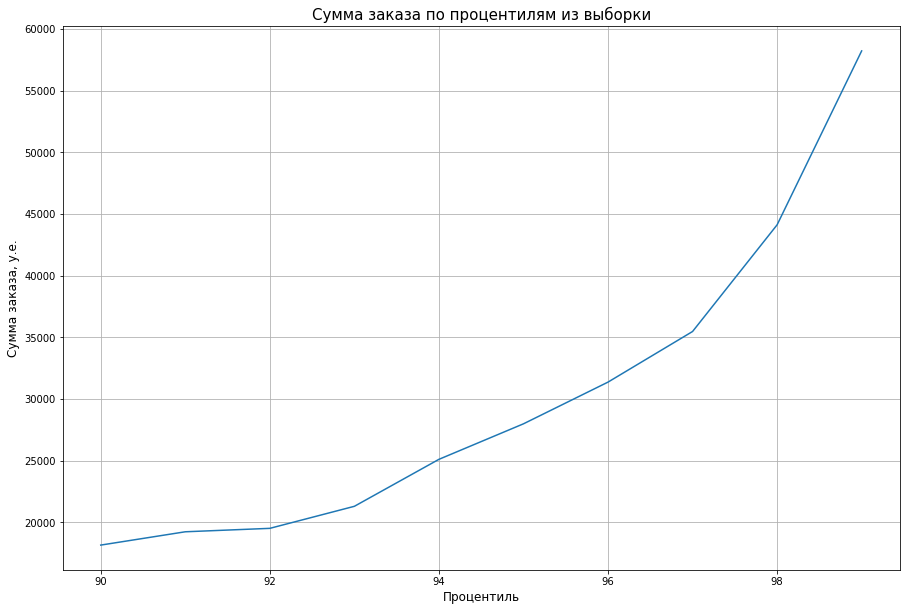

In [50]:
plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Сумма заказа по процентилям из выборки', fontsize=15)

plt.plot(
    percentiles['percentile'],
    percentiles['value'])

plt.xlabel('Процентиль', fontsize=12)
plt.ylabel('Сумма заказа, у.е.', fontsize=12)

plt.show()

1. 4 процентных пункта выборки дают двухкратный рост стоимости заказа (c 28 до 58.2)
2. Числовые значения суммы заказа при расчете процентилей, а также уровень наклона графика говорят нам о том, что с 97 процентиля включительно частота дискретизации заказов падает и рост суммы становится относительно большим, а угол наклона графика увеличивается. Предположительно, необходимо **в качестве ограничения суммы заказа использовать 96й процентиль, то есть сумму в 31382 условных единицы**

## Cтатистическая значимость различий в конверсии между группами по «сырым» данным

In [51]:
#сформируем датафреймы, в которые запишем количество заказов для каждого пользователя с разделением по группам теста
ordersByUsers_A = orders[orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers_A.columns=['user_id', 'orders']
ordersByUsers_B = orders[orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers_B.columns=['user_id', 'orders']

In [52]:
#к series из таблицы с идентификаторами пользователей и количеством совершенным ими заказов присоединяем 
#количество нулевых значение, равное разности между количеством посещений сайта и количеством заказов для 
#каждой группы
sample_A = pd.concat(
    [
        ordersByUsers_A['orders'],
        pd.Series(
            0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum()
                              - len(ordersByUsers_A['orders'])), name='orders')
    ], axis=0)

sample_B = pd.concat(
    [
        ordersByUsers_B['orders'],
        pd.Series(
            0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum()
                              - len(ordersByUsers_B['orders'])), name='orders')
    ], axis=0)

В соответствии с правилами формулирования гипотез:

- **Нулевая гипотеза (H₀): Между конверсией двух групп нет статистически значимой разницы = то есть конверсия не изменилась**
- **Альтернативная гипотеза: Между конверсиями групп есть статистически значимая разница = конверсия изменилась**

In [53]:
print("Вероятность того, что текущее или большее различие получено случайно: {0:.5f}%".format(stats.mannwhitneyu(
    sample_A,
    sample_B,
    alternative = 'two-sided'
)[1]*100))
print('Прирост конверсии для группы В составляет: {0:.2f}%'.format((sample_B.mean()/sample_A.mean()-1)*100)) 

Вероятность того, что текущее или большее различие получено случайно: 1.67924%
Прирост конверсии для группы В составляет: 13.81%


In [54]:
alpha = 0.05

if stats.mannwhitneyu(sample_A, sample_B, alternative = 'two-sided')[1] < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


Таким образом, статистической значимости между конверсиями двух групп по "сырым" данным показывает, что между группами есть статистически значимое отличие.

## Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

В соответствии с правилами формулирования гипотез:

- **Нулевая гипотеза (H₀): Между средними чеками групп нет статистически значимой разницы**
- **Альтернативная гипотеза: Между конверсиями групп есть статистически значимая разница**

In [55]:
print("Вероятность того, что текущее или большее различие получено случайно: {0:.5f}%".format(
    stats.mannwhitneyu(
        orders[orders['group'] == 'A']['revenue'], 
        orders[orders['group'] == 'B']['revenue'],
        alternative = 'two-sided'
    )[1]*100))

Вероятность того, что текущее или большее различие получено случайно: 72.92910%


In [56]:
alpha = 0.05

if stats.mannwhitneyu(
    orders[orders['group'] == 'A']['revenue'],
    orders[orders['group'] == 'B']['revenue'],
    alternative = 'two-sided'
)[1] < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Не получилось отвергнуть нулевую гипотезу


p-value более 72%, что не позволяет нам отвергнуть нулевую гипотезу об отсутствии статистически значимых различий средних чеков двух групп. Таким образом, мы можем сделать предположение, что сумма среднего чека осталась примерно такой же. 

## Cтатистическая значимость различий в конверсии между группами по «очищенным» данным

Для оценки статистической значимости различий по очищенным данным нам потребуется изолировать "аномальных" пользователей. 

In [57]:
#в соответствии с ранее определенными значениями, мы отбираем пользователей с более чем 2 заказами и суммами заказов
#более суммы 96го перцентиля
users_w_too_many_orders = ordersByUsers[ordersByUsers['orders'] > 2]['user_id'] 
users_w_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 96)]['visitorId']

In [58]:
#конкатенацией соединяем оба series и убираем дубликаты
abnormal_users = pd.concat(
    [
    users_w_too_many_orders, 
    users_w_expensive_orders
    ],axis=0
).drop_duplicates()

In [59]:
print('Количество "аномальных" пользователей:', len(abnormal_users))

Количество "аномальных" пользователей: 72


In [60]:
#по аналогии с ранее произведенной операцией формирования series сформируем семплы для анализа выборки
#но включим в код условие, которым исключим "аномальных" пользователей из списка
sample_A = pd.concat(
    [
        ordersByUsers_A[
            np.logical_not(ordersByUsers_A['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum()
                              - len(ordersByUsers_A['orders'])), name='orders')
    ], axis=0)

sample_B = pd.concat(
    [
        ordersByUsers_B[
            np.logical_not(ordersByUsers_B['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum()
                              - len(ordersByUsers_B['orders'])), name='orders')
    ], axis=0)

В соответствии с правилами формулирования гипотез:


- **Нулевая гипотеза (H₀): Между конверсией двух групп нет статистически значимой разницы = то есть конверсия не изменилась**
- **Альтернативная гипотеза: Между конверсиями групп есть статистически значимая разница = конверсия изменилась**

In [61]:
print("Вероятность того, что текущее или большее различие получено случайно: {0:.5f}%".format(stats.mannwhitneyu(
    sample_A,
    sample_B,
    alternative = 'two-sided'
)[1]*100))
print('Прирост конверсии для группы В составляет: {0:.2f}%'.format((sample_B.mean()/sample_A.mean()-1)*100)) 

Вероятность того, что текущее или большее различие получено случайно: 0.88986%
Прирост конверсии для группы В составляет: 18.24%


In [62]:
alpha = 0.05

if stats.mannwhitneyu(
    sample_A,
    sample_B,
    alternative = 'two-sided'
)[1] < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


1. p-value снизилось вдвое. Вероятно, удаление выбросов помогло обозначить различие еще более очевидно. Таким образом, делаем вывод, что между выборками существует статистически значимая разница
2. Также на очищенных данных мы наблюдаем прирост в отношении конверсии группы В к группе А на 4.5 процентных пункта

## Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [63]:
#добавляем внутри функции print условие, исключающее "аномальных" пользователей из сравниваемых выборок

print("Вероятность того, что текущее или большее различие получено случайно: {0:.5f}%".format(
    stats.mannwhitneyu(
        orders[
            np.logical_and(
                orders['group'] == 'A', 
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'],
        orders[
            np.logical_and(
                orders['group'] == 'B', 
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'],
        alternative = 'two-sided'
    )[1]*100))

print("Отношение среднего чека заказа в группе В к группе А: {0:.1f}%".format(
        orders[
            np.logical_and(
                orders['group'] == 'B', 
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'].mean() / 
        orders[
            np.logical_and(
                orders['group'] == 'A', 
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
    ))

Вероятность того, что текущее или большее различие получено случайно: 93.24526%
Отношение среднего чека заказа в группе В к группе А: 1.0%


В соответствии с правилами формулирования гипотез:

- **Нулевая гипотеза (H₀): Между средними чеками групп нет статистически значимой разницы**
- **Альтернативная гипотеза: Между конверсиями групп есть статистически значимая разница**

In [64]:
#проверим гипотезу
alpha = 0.05

if stats.mannwhitneyu(orders[
            np.logical_and(
                orders['group'] == 'A', 
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'],
        orders[
            np.logical_and(
                orders['group'] == 'B', 
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'], alternative = 'two-sided')[1] < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Не получилось отвергнуть нулевую гипотезу


Мы наблюдаем рост p-value при анализе очищенных данных на 10 процентных пунктов. Таким образом, по очищенным данным мы также наблюдаем отсутствие статистически значимых отличий в средних чеках заказов. 

## Решение по результатам теста

**Для принятия решения о результате теста примем во внимание следующие факты:** 

1. Анализ динамики выручки по группам показал, что группа В в начале теста находилась примерно на одном уровне с группой А, но в середине теста между группами образовался и сохранился разрыв
2. Анализ среднего чека также показал также существенное различие на графиках между двумя группами (для группы А во второй половине средний чек находился на уровне 7000, а для группы В на уровне 9000 условных единиц)
3. Анализ конверсии также показал более высокие значения для группы В: с 6 августа наметилась тенденция на фиксацию различия в конверсии между группами (в группе А конверсия колеблется у отметки в 3%, а в группе В в диапазоне 3.3-3.6%)
4. Проверка гипотез об отсутствии/наличии статистически значимых различий между группами показала следующее: 
    + Группа В имеет статистически значимое различие в конверсии относительно группы А
        - Для "сырых" данных прирост группы В оказался на уровне 13.8%
        - Для "очищенных" данных прирост группы В поднялся примерно на 4.5 процентных пункта до отметки в 18.2%
    + Группы В и А не имеют статистически значимых отличий в сумме среднего чека 

**Таким образом, в зависимости от вводных решения по результатам теста могут быть следующими:**

1. Если проверяемая гипотеза предполагала увеличение конверсии, то результат теста положительный - тест можно завершить и зафиксировать "победу" группы В
2. Если проверяемая гипотеза предполага увеличение среднего чека, то рекомендуется продлить тест, так как статистически значимых отличий между группами не зафиксировано, но визуальное представление финансовых данных наводит на мысль о том, что в середине теста возникла какая-то аномалия, обусловленная непрогнозируемым фактором

# Общий вывод

1. После проведения приоритизации гипотез с использованием фреймворков ICE и RICE были определены топ 4 гипотез с наивысшими оценками с учетом охвата аудитории:
    + "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" 
    + "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
    + "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
    + "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию" 
2. Следует обратить внимание, что первые две гипотезы показил значительное изменение положения в рейтинге при анализе при помощи RICE, так как предположительно охватывают большую аудиторию (+2 и +3 позиции для 1 и 2 второй гипотез соответственно)
3. Анализ кумулятивной выручки за период тест показал больший ее рост в группе В (около 6 млн против 4 млн) к моменту окончания теста. Однако на графике можно наблюдать необычную динамику роста в группе "В" с 17-18 августа 2019 года
4. Аналогичную аномалию можно наблюдать на графике, отражающем средний чек по кумулятивным данным за период теста: на графике наблюдается скачок с 7 до 10 тысяч 18 августа с дальнейшим плавным снижением примерно до отметки 9.2 тысячи
5. Также мы наблюдаем повышение уровня конверсии в группе В: с 6 августа намечается тенденция на фиксацию относительно устойчивого различия в конверсии между группами (в группе А конверсия колеблется у отметки в 3%, а в группе В в диапазоне 3.3-3.6%
6. Визуальное представление данных наводит на мысль о росте среднего чека в группе В параллельно с ростом конверсии, однако проверка статистически значимых различий в среднем чеке и уровне конверсии между группами показал: 
    + Есть статистически значимая разница в уровне конверсии: 
        - По "сырым" данным прирост конверсии на уровне 14%
        - По "очищенным" данными прирост конверсии на уровне 18%
    + Статистически значимой разницы в среднем чеке между группами нет
   
**Рекомендуется:**

1. Зафиксировать успех и завершить тест, если изначальная гипотеза предполагала рост конверсии
2. Продолжить тест, если изначальная гипотеза предполагала рост среднего чека, так как наблюдаются труднообъяснимые на текущий момент колебания суммы среднего чека на графиках, что может говорить о недостаточной продолжительности теста для однозначной фиксации результата